### **Install packages and libraries**

In [ ]:
# pip install packages
!pip install gseapy
!pip install mygene
!pip install gprofiler-official
!pip install gseapy networkx matplotlib

In [ ]:
# install libraries
import pandas as pd
import matplotlib.pyplot as plt
from gprofiler import GProfiler
from collections import defaultdict
import mygene
import gseapy as gp
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests


### **Load, Inspect, and Clean Data**

In [ ]:
# get data from GEO and decompress file
!wget -O GSE95077_Normalized_Count_Matrix_JJN3_Amiloride_and_CTRL.txt.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE95077&format=file&file=GSE95077%5FNormalized%5FCount%5FMatrix%5FJJN3%5FAmiloride%5Fand%5FCTRL%2Etxt%2Egz'
!gunzip GSE95077_Normalized_Count_Matrix_JJN3_Amiloride_and_CTRL.txt

--2024-08-19 13:53:12--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE95077&format=file&file=GSE95077%5FNormalized%5FCount%5FMatrix%5FJJN3%5FAmiloride%5Fand%5FCTRL%2Etxt%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342237 (334K) [application/octet-stream]
Saving to: ‘GSE95077_Normalized_Count_Matrix_JJN3_Amiloride_and_CTRL.txt.gz’

GSE95077_Normalized 100%[===================>] 334.22K  1.05MB/s    in 0.3s    

2024-08-19 13:53:13 (1.05 MB/s) - ‘GSE95077_Normalized_Count_Matrix_JJN3_Amiloride_and_CTRL.txt.gz’ saved [342237/342237]

gzip: GSE95077_Normalized_Count_Matrix_JJN3_Amiloride_and_CTRL.txt: unknown suffix -- ignored


In [ ]:
# load data into pandas dataframe
file_path = 'GSE95077_Normalized_Count_Matrix_JJN3_Amiloride_and_CTRL.txt'
data_frame = pd.read_csv(file_path, sep='\t', index_col=0)

In [ ]:
# inspect first 5 rows of data frame
data_frame.head()

,JJ_AMIL_141050_INTER-Str_counts,JJ_AMIL_141056_INTER-Str_counts,JJ_AMIL_141062_INTER-Str_counts,JJ_CTRL_141048_INTER-Str_counts,JJ_CTRL_141054_INTER-Str_counts,JJ_CTRL_141060_INTER-Str_counts
ENSG00000000419,1520.00,2420.00,2820.00,1880.00,1610.00,1760.00
ENSG00000000457,675.00,765.00,772.00,777.00,744.00,795.00
ENSG00000000460,1110.00,1060.00,855.00,999.00,906.00,791.00
ENSG00000000938,3.96,2.41,3.68,1.13,3.43,1.28
ENSG00000000971,3000.00,2570.00,2810.00,2820.00,2450.00,2560.00


In [ ]:
# check for missing values
print(data_frame.isnull().sum())

JJ_AMIL_141050_INTER-Str_counts    0
JJ_AMIL_141056_INTER-Str_counts    0
JJ_AMIL_141062_INTER-Str_counts    0
JJ_CTRL_141048_INTER-Str_counts    0
JJ_CTRL_141054_INTER-Str_counts    0
JJ_CTRL_141060_INTER-Str_counts    0
dtype: int64


Notes:
- No null (missing) values and all samples total counts (gene IDs) are the same.
- Since index is ensemble ID's we'll want to convert that to gene names using next code block


In [ ]:
# get corresponding gene names for ea/ ensemble ID and add gene names to new column
mg = mygene.MyGeneInfo()
ensembl_ids = data_frame.index.tolist()
gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')
gene_df = pd.DataFrame(gene_info)
gene_df = gene_df.dropna(subset=['symbol']).drop_duplicates(subset='query')
data_frame['Gene_Name'] = data_frame.index.map(gene_df.set_index('query')['symbol'])
cols = ['Gene_Name'] + [col for col in data_frame.columns if col != 'Gene_Name']
data_frame = data_frame[cols]

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

In [ ]:
# drop current index w/ ensemble IDs, then make column 0 w/ gene names the new index
data_frame = data_frame.reset_index(drop=True)
data_frame = data_frame.set_index(data_frame.columns[0])
data_frame.head()

,JJ_AMIL_141050_INTER-Str_counts,JJ_AMIL_141056_INTER-Str_counts,JJ_AMIL_141062_INTER-Str_counts,JJ_CTRL_141048_INTER-Str_counts,JJ_CTRL_141054_INTER-Str_counts,JJ_CTRL_141060_INTER-Str_counts
Gene_Name,,,,,,
DPM1,1520.00,2420.00,2820.00,1880.00,1610.00,1760.00
SCYL3,675.00,765.00,772.00,777.00,744.00,795.00
FIRRM,1110.00,1060.00,855.00,999.00,906.00,791.00
FGR,3.96,2.41,3.68,1.13,3.43,1.28
CFH,3000.00,2570.00,2810.00,2820.00,2450.00,2560.00


### **Exploratory Data Analysis**
- Explore the distribution and variability in the dataset, as demonstrated in the code block below.


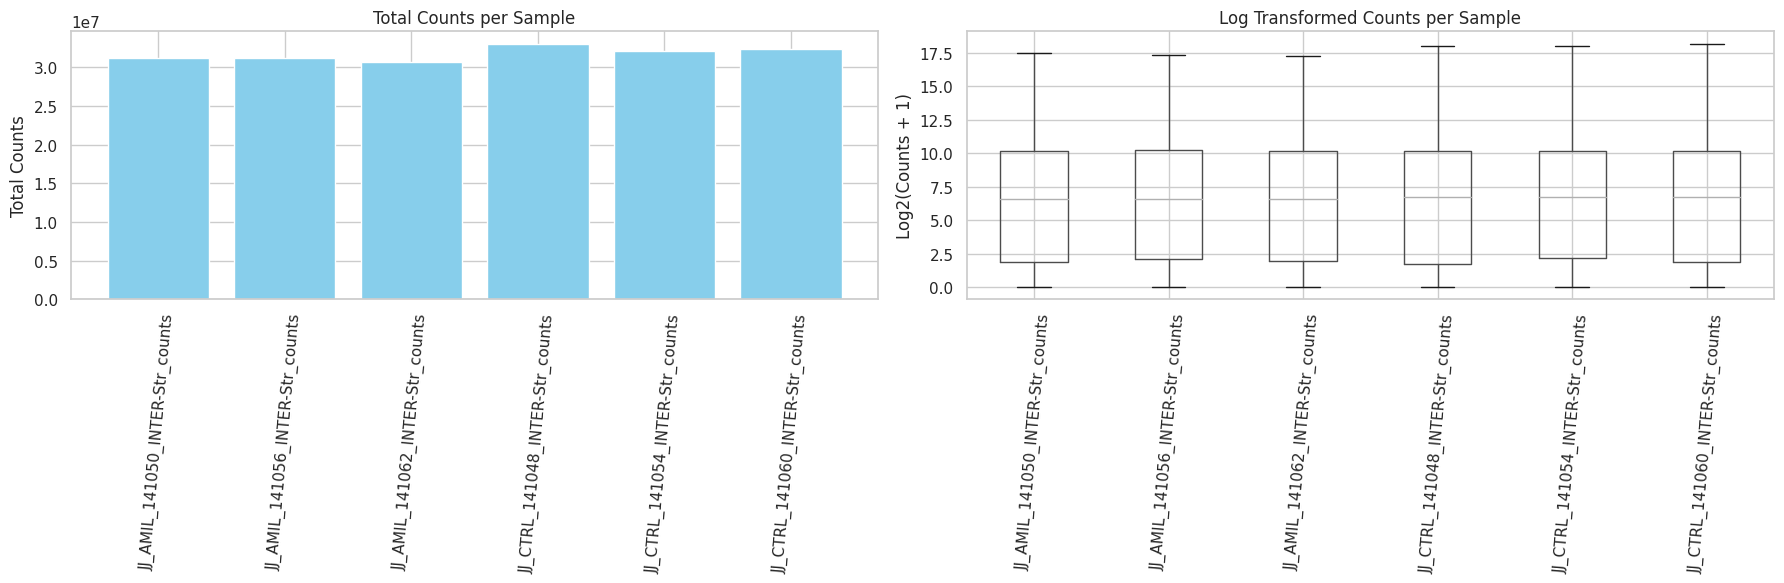

In [ ]:
# calcualte total counts per sample and log transform counts
total_counts = data_frame.sum(axis=0)
log_counts = data_frame.apply(lambda x: np.log2(x + 1))

# create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# subplot 1: total counts per sample
axes[0].bar(data_frame.columns, total_counts, color='skyblue')
axes[0].set_ylabel('Total Counts')
axes[0].set_title('Total Counts per Sample')
axes[0].tick_params(axis='x', rotation=85)

# subplot 2: log transformed counts per sample
log_counts.boxplot(ax=axes[1])
axes[1].set_ylabel('Log2(Counts + 1)')
axes[1].set_title('Log Transformed Counts per Sample')
axes[1].tick_params(axis='x', rotation=85)

plt.tight_layout()
plt.show()

Notes:
- The chart on the left, titled "Total Counts," helps visualize the overall sequencing depth across the samples. Ideally, the bars, representing the total counts, should be of similar height, indicating that sequencing depth is consistent across samples, which is the case with this data set.
- Conversely, the rightmost chart is used to assess the variability and distribution of gene expression counts across samples. In this case, we can see that the boxes, representing the interquartile range, and the whiskers, representing variability outside the upper and lower quartiles, are of similar sizes across the samples, indicating a consistent data distribution.

Now, before moving on to quality control and filtering, we'll use one last visualization to explore the similarity, or dissimilarity, between our six samples:



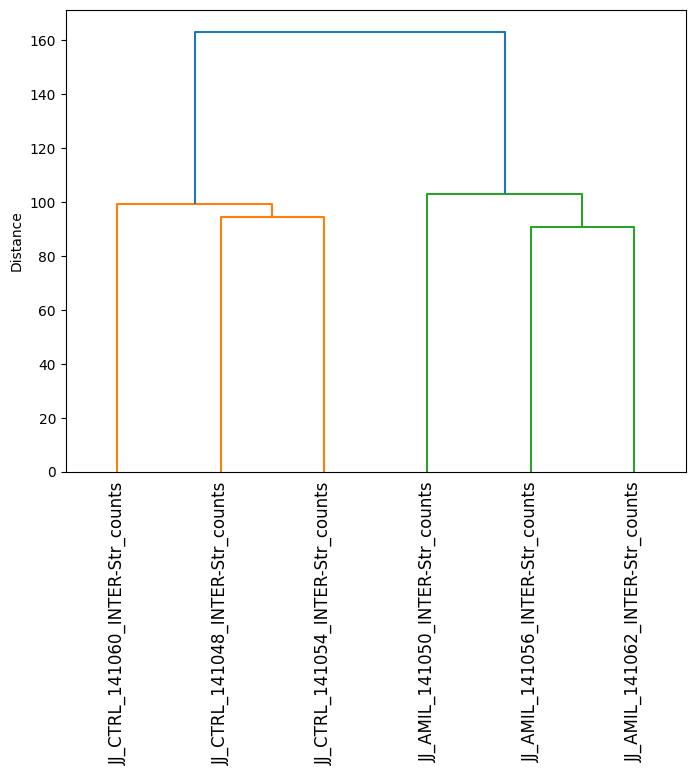

In [ ]:
h_clustering = linkage(log_counts.T, 'ward')
plt.figure(figsize=(8, 6))
dendrogram(h_clustering, labels=data_frame.columns)
plt.xticks(rotation=90)
plt.ylabel('Distance')
plt.show()

Notes:
- The image above shows the results of hierarchical clustering, which can be visualized via a dendrogram. When viewing a dendrogram, special attention should be paid to the cluster groupings and branches. Samples clustered together are more similar to each other, and the length of the branches (vertical lines) connecting clusters represents the distance or dissimilarity between clusters.
- The chart above shows that our three control samples are clustered on the left, whereas our three experimental (i.e.,m amiloride-exposed) samples are clustered together on the right. This is a good sign, suggesting that the control and experimental groups are distinct and that there is biological variation between the two groups of samples. Thus, we can feel confident that our downstream differential expression analyses will provide meaningful results.

### **Quality Control, Filtering, and Normalization**

Notes:
- The next step in our analysis is to filter out genes with low expression levels across all samples, which can introduce noise in the data. By filtering these out, you can make your results more reliable and improve your statistical power, making detecting real biological differences between conditions easier.
- Additionally, filtering out genes with low expression counts decreases computational load by reducing the number of genes in your dataset, making future downstream analyses faster.

To determine filtering criteria i'll use the following chart....



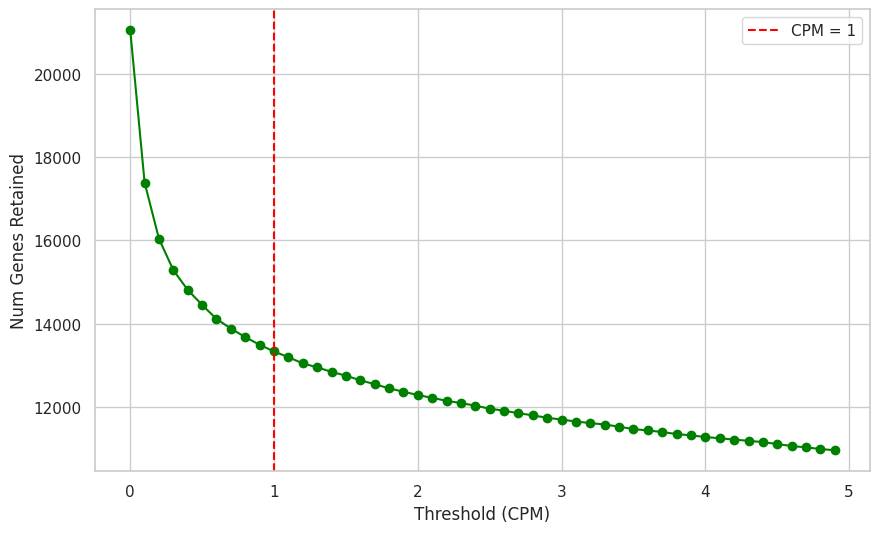

In [ ]:
def plot_genes_retained_by_cpm(data, min_samples=3):
    cpm = data.apply(lambda x: (x / x.sum()) * 1e6)  # Convert raw counts to CPM
    thresholds = np.arange(0, 5, 0.1)  # Test CPM thresholds from 0 to 5 in 0.1 increments
    genes_retained = []

    for min_cpm in thresholds:
        mask = (cpm > min_cpm).sum(axis=1) >= min_samples
        genes_retained.append(mask.sum())  # Count number of genes retained

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, genes_retained, marker='o', color='green')
    plt.axvline(x=1.0, color='red', linestyle='--', label='CPM = 1') #put line at 1 as rough heuristic
    plt.xlabel('Threshold (CPM)')
    plt.ylabel('Num Genes Retained')
    plt.legend()
    plt.show()

plot_genes_retained_by_cpm(data_frame)

Notes:
- Based on chart above i'll filter genes w/ expression threshold of <0.75 CPM
- For many bulk RNA-seq datasets, a CPM threshold of 1 is a common filtering point, but 0.75 is slightly more lenient and might be justified if we have reasons to suspect that some lower-expressed genes could still be important.

In [ ]:
def filter_normalize(data, min_cpm=0.75, min_samples=3):
    # filter genes based on CPM thresholds
    cpm = data.apply(lambda x: (x / x.sum()) * 1e6)  # Convert raw counts to CPM
    mask = (cpm > min_cpm).sum(axis=1) >= min_samples  # Keep genes with CPM > min_cpm in min_samples
    filtered_data = data[mask]

    # Apply global scaling normalization
    geometric_means = filtered_data.apply(lambda row: np.exp(np.log(row[row > 0]).mean()), axis=1)
    size_factors = filtered_data.div(geometric_means, axis=0).median(axis=0)
    normalized_data = filtered_data.div(size_factors, axis=1)

    return pd.DataFrame(normalized_data, index=filtered_data.index, columns=filtered_data.columns)

# Overwrite dataframe with filtered and normalized data
data_frame = filter_normalize(data_frame)


### **Differential Expression Analysis**

In [ ]:
results = []
for gene in data_frame.index:
    control = data_frame.loc[gene, ['JJ_AMIL_141050_INTER-Str_counts', 'JJ_AMIL_141056_INTER-Str_counts', 'JJ_AMIL_141062_INTER-Str_counts']]
    treated = data_frame.loc[gene, ['JJ_CTRL_141048_INTER-Str_counts', 'JJ_CTRL_141054_INTER-Str_counts', 'JJ_CTRL_141060_INTER-Str_counts']]
    mean_control = np.mean(control)
    mean_treated = np.mean(treated)
    log2fc = np.log2((mean_treated + 1) / (mean_control + 1))  # Adding 1 to avoid log of 0
    t_stat, p_val = ttest_ind(control, treated)
    results.append({'gene': gene, 'log2fc': log2fc, 't_stat': t_stat, 'p_val': p_val})

results_df = pd.DataFrame(results)

In [ ]:
# Convert p_val to numeric, coercing errors to NaN
results_df['p_val'] = pd.to_numeric(results_df['p_val'], errors='coerce')

# drop NAN
results_df = results_df.dropna(subset=['p_val'])
pvals = results_df['p_val'].values  # Convert to numpy array

results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

results_df['abs_log2fc'] = results_df['log2fc'].abs()

deg = results_df[(results_df['p_adj'] < 0.05) & (results_df['abs_log2fc'] > 1)]

<ipython-input-59-29850c7b731d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]
<ipython-input-59-29850c7b731d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['abs_log2fc'] = results_df['log2fc'].abs()


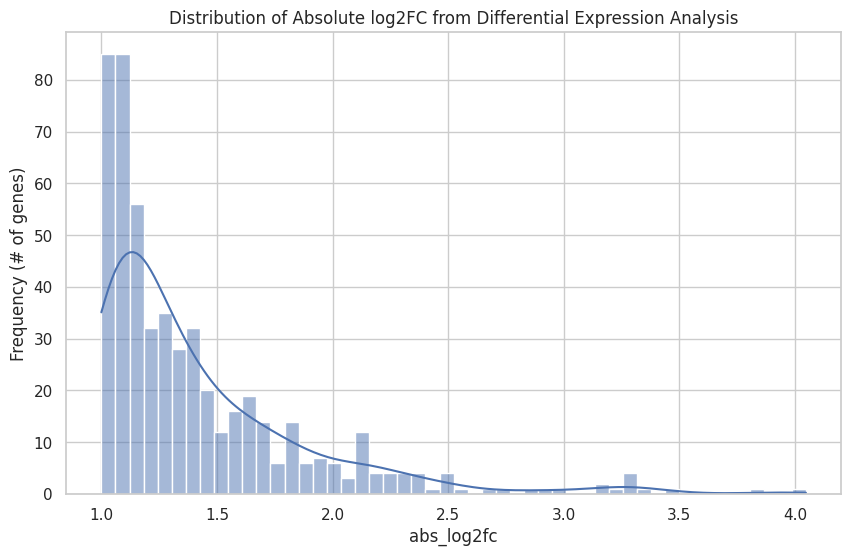

In [ ]:
# view distribution of scores
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(deg['abs_log2fc'], bins=50, kde=True)
plt.title('Distribution of Absolute log2FC from Differential Expression Analysis')
plt.xlabel('abs_log2fc')
plt.ylabel('Frequency (# of genes)')
plt.show()

## **visualizing differentially expressed genes:**
- The first visualization we'll use to understand our data is a volcano plot. A volcano plot is a type of scatter plot commonly used in genomics and other areas of bioinformatics to visualize the results of differential expression analysis and help identify statistically significant changes in gene expression between different conditions. In the code block below, I'll demonstrate how to create a volcano plot using our data frame of filtered differentially expressed genes. The first plot will be from our results_df DataFrame before filtering, then the second plot will be from our deg DataFrame, a after filtering out genes that do not meet our selection criteria:



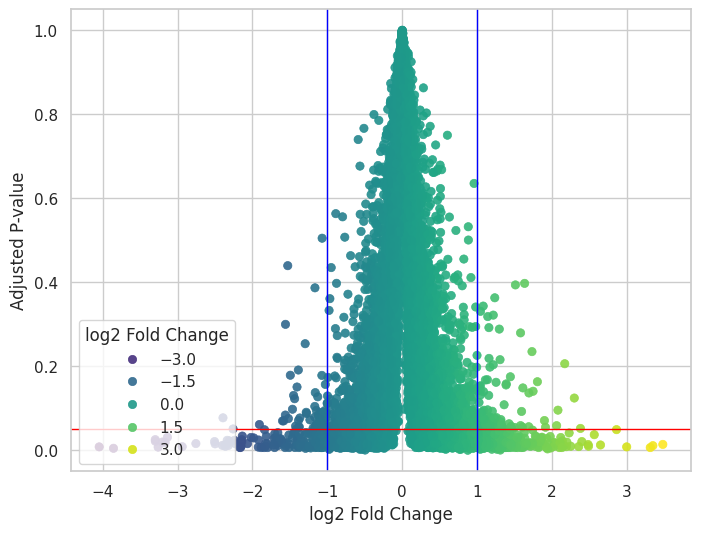

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None)
plt.axhline(y=0.05, color='red', linestyle='-', linewidth=1)
plt.axvline(x=1, color='blue', linestyle='-', linewidth=1)
plt.axvline(x=-1, color='blue', linestyle='-', linewidth=1)
plt.xlabel('log2 Fold Change')
plt.ylabel('Adjusted P-value')
plt.legend(title='log2 Fold Change', loc='lower left')
plt.show()

As you can see in the image above, our volcano plot combines two critical pieces of information for each gene: the magnitude of change (fold change) and the statistical significance (p-value) of that change. Specifically, the x-axis on this graph shows the log2 fold change between the control and experimental samples in our pairwise analysis. A positive value indicates an upregulation of a gene in the experimental group compared to the control, and a negative value represents downregulation of a gene in the experimental group compared to the control. Additionally, the y-axis shows the significance of said change in gene expression. Thus, when viewing this graph, we are most interested in the two boxes formed in the lower left and lower right corners, which represent down-regulated and up-regulated genes with high statistical significance.

Now, in the code block below, I'll show you how to produce a volcano plot containing only genes that met our filtering criteria:



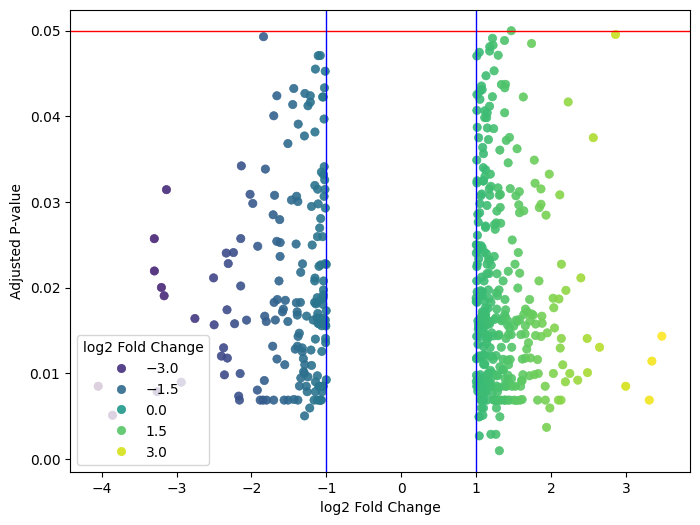

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=deg, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None)
plt.axhline(y=0.05, color='red', linestyle='-', linewidth=1)
plt.axvline(x=1, color='blue', linestyle='-', linewidth=1)
plt.axvline(x=-1, color='blue', linestyle='-', linewidth=1)
plt.xlabel('log2 Fold Change')
plt.ylabel('Adjusted P-value')
plt.legend(title='log2 Fold Change', loc='lower left')
plt.show()

Notably, the data in this second volcano plot is much more sparse, as it only contains genes that met our filtering criteria of an adjusted p-value <0.5 and a log2 fold change >1. However, this plot does little to show us how these genes are related to one another, which will help us unravel amiloride's physiological effects. To better understand that, we can perform hierarchical clustering, which can help us understand how genes with differential expression are related and identify clusters of genes that may be similarly affected by the drug treatment.

The first hierarchical clustering visualization we'll explore is a heatmap, which provides an integrated view of the data, showing not only how samples or features group together but also the magnitude of their values. In this code block below, I'll show you how to create this type of visualization:



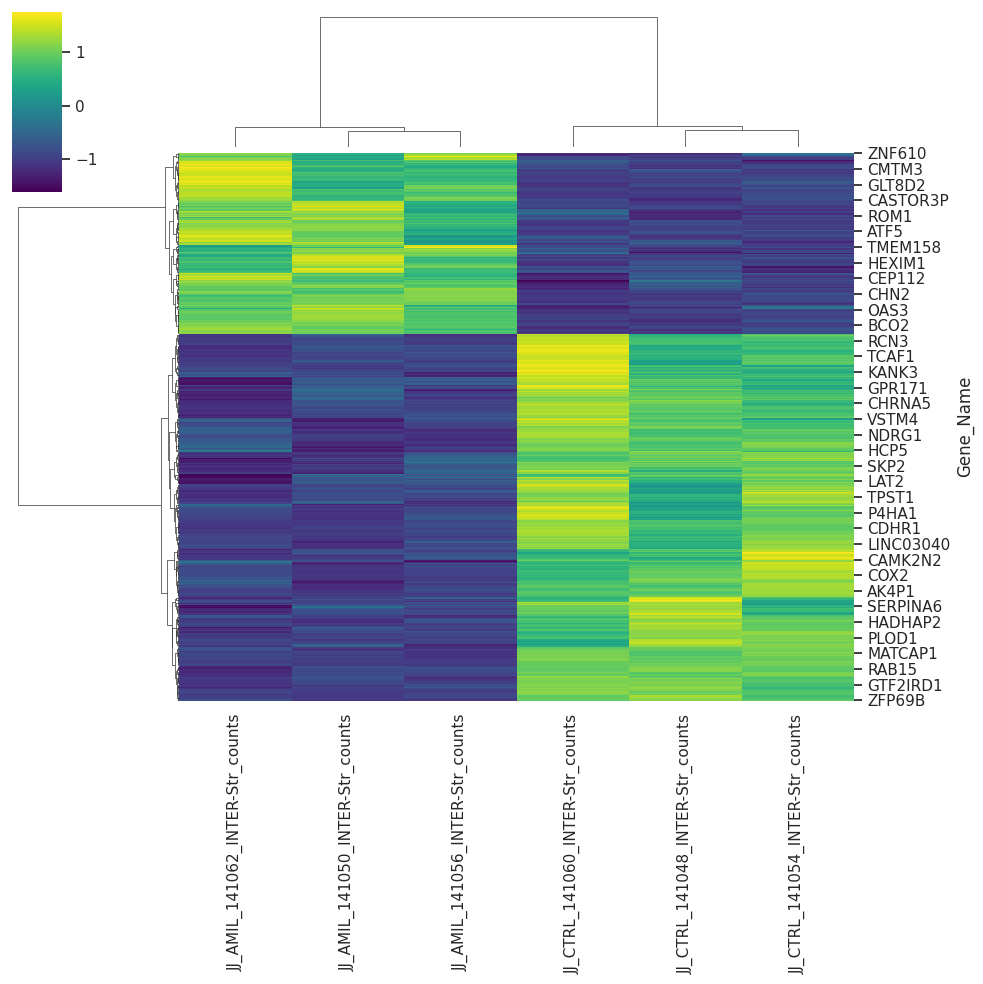

In [ ]:
significant_genes = deg['gene'].tolist()
data_sig = data_frame.loc[significant_genes]
scaler = StandardScaler()
data_sig_scaled = pd.DataFrame(scaler.fit_transform(data_sig.T).T, index=data_sig.index, columns=data_sig.columns)
sns.clustermap(data_sig_scaled, method='ward', cmap='viridis', metric='euclidean', figsize=(10, 10), dendrogram_ratio=(0.2, 0.2))
plt.show()

Next, we'll perform functional enrichment analysis, which.... etc

## **Functional enrichment analysis**

Notes:
- Pathway Analysis: Given that you are studying the effects of a cancer drug, pathway analysis is particularly useful as it helps identify specific biological processes and pathways that the drug affects. This can provide insights into the drug’s mechanism of action and its impact on cellular functions. For instance, identifying pathways related to energy metabolism and oxidative stress can directly link to how the drug alters cellular processes relevant to cancer.
- GO Analysis: GO analysis complements pathway analysis by providing a broader functional understanding of how genes are affected at the level of biological processes, molecular functions, and cellular components. It can highlight general biological changes but might not always pinpoint specific pathways affected by the drug.

In [ ]:
# Extract the list of gene names for DEGs

gene_list = deg['gene'].tolist()

# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

# Perform GO analysis using the significant gene list
go_results = gp.profile(organism='hsapiens', query=gene_list)

# Display the first few results
print(go_results.head())

  source      native                              name       p_value  \
0  GO:CC  GO:0005737                         cytoplasm  3.213865e-11   
1     HP  HP:0001427         Mitochondrial inheritance  1.419640e-09   
2     HP  HP:0000576               Centrocecal scotoma  5.379318e-09   
3  GO:BP  GO:0044281  small molecule metabolic process  1.289483e-08   
4     HP  HP:0001112               Leber optic atrophy  1.425304e-08   

   significant                                        description  term_size  \
0         True  "The contents of a cell excluding the plasma m...      12345   
1         True  A mode of inheritance that is observed for tra...         16   
2         True  A scotoma (area of diminished vision within th...         13   
3         True  "The chemical reactions and pathways involving...       1813   
4         True  Degeneration of retinal ganglion cells and the...         10   

   query_size  intersection_size  effective_domain_size  precision    recall  \
0     

In [ ]:
# perform pathway analysis
pathway_analysis_results = gp.profile( organism='hsapiens',  query=gene_list, sources=["KEGG", "REAC"])

# display the results
print(pathway_analysis_results.head())

  source              native  \
0   REAC  REAC:R-HSA-1428517   
1   KEGG          KEGG:00190   
2   KEGG          KEGG:01100   
3   KEGG          KEGG:05208   
4   REAC   REAC:R-HSA-163200   

                                                name   p_value  significant  \
0  The citric acid (TCA) cycle and respiratory el...  0.000031         True   
1                          Oxidative phosphorylation  0.000243         True   
2                                 Metabolic pathways  0.000276         True   
3  Chemical carcinogenesis - reactive oxygen species  0.000334         True   
4  Respiratory electron transport, ATP synthesis ...  0.001286         True   

                                         description  term_size  query_size  \
0  The citric acid (TCA) cycle and respiratory el...        177         266   
1                          Oxidative phosphorylation        134         196   
2                                 Metabolic pathways       1537         196   
3  Chemical carc

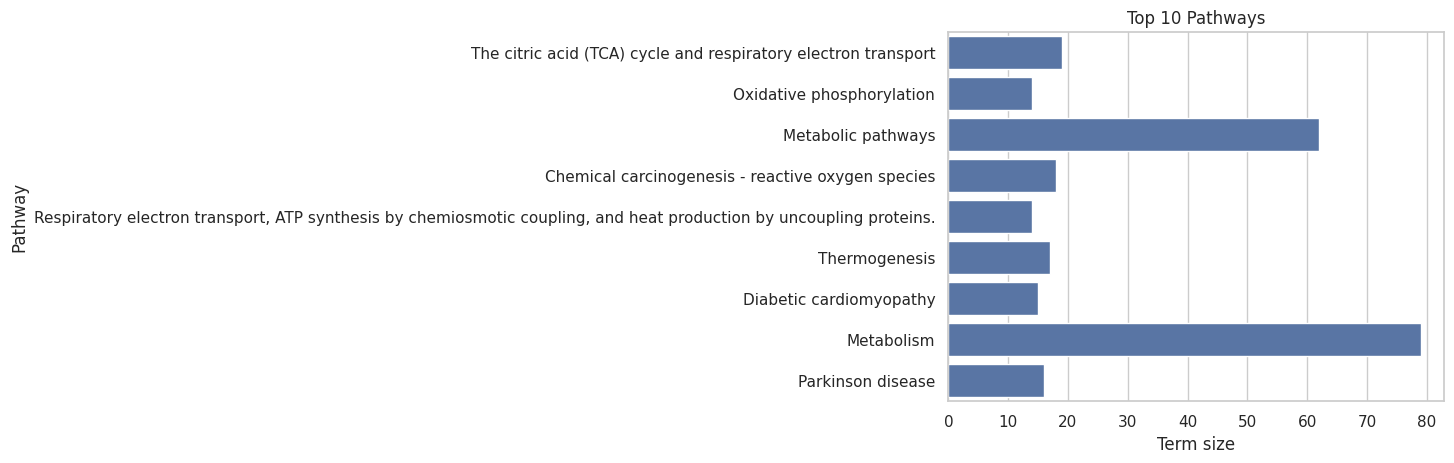

In [ ]:
sns.barplot(x='intersection_size', y='name', data=pathway_analysis_results.head(10))
plt.title('Top 10 Pathways')
plt.xlabel('Term size')
plt.ylabel('Pathway')
plt.show()